In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.datasets import make_blobs, make_classification
from sklearn.neighbors import DistanceMetric
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler

from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.stats import multivariate_normal

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Categorical

import multiprocessing as mp
from pprint import pprint
from tqdm import tqdm

# Actor

Build an actor to assign each sample to a specific cluster according to the policy(categorical distribution) it has, which will get improved through the training process.

In [2]:
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim, units=32):
        super(Actor, self).__init__()
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(in_features=self.obs_dim, out_features=units)
        self.fc2 = nn.Linear(units, self.action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Categorical(logits=logits)
        action = m.sample()
        log_p = m.log_prob(action)
        
        return action, log_p, logits

# Utility Functions

In [8]:
def get_data(x, batch_size=32):
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :]


def metrics(label, y_pred):
    return adjusted_rand_score(label, y_pred), adjusted_mutual_info_score(label, y_pred)


def observed_loglikelihood(x, pi, mu, sigma):
    log_p = []
    for i in range(x.shape[0]):
        l_i = [p * multivariate_normal.pdf(x[i, :], m, s) for p, m, s in zip(pi, mu, sigma)]
        log_p.append(np.log(np.sum(l_i)))
    return log_p

# Evaluator

Bulid an evaluator to output a reward for each assignment of the actor.

The reward can be model-based if we assume the distribution of the data (e.g. Gaussian mixture). It can also be model-free which is achieved by using spectral analysis and linear discriminant analysis to contrust a novel reward.

In [4]:
def compute_reward(x, K, actions, log_probs, dictionary, model_based=True):
    '''
    The purpose of the dictionary is to prevent the situation where a cluster is not assigned enough data to calculate the mean and variance. 
    We can assign the values in the dictionary to such clusters.
    '''
    _, dim_x = x.shape
    reward_list = []
    mu_hat = []
    sigma_hat = []
    for k in range(K):
        # print((actions == k).sum())
        if (actions == k).sum() == 0:
            print('mu can not be calculated')
            mu_hat.append(dictionary[k]['mu'])
        else:
            mu_hat.append(np.mean(x[actions == k, :], axis=0))
        
        if (actions == k).sum() <= dim_x+1:    # 变量维数
            print('cov can not be calculated')
            sigma_hat.append(dictionary[k]['sigma'])  
        else:
            sigma_hat.append(np.cov(x[actions==k, :], rowvar=False))
    
    pi_hat = [(actions == i).sum() / actions.size for i in range(K)]

          
    if model_based:
    ## model-based reward    
        reward_list = observed_loglikelihood(x, pi_hat, mu_hat, sigma_hat)
    else:
    ## model-free reward
        # intra-class distance
        s_w = 0
        for k in range(K):
            dist = DistanceMetric.get_metric('euclidean')  # 'mahalanobis', V=sigma_hat[k]; 'euclidean'
            if (actions == k).sum() == 0:
                s_wk = 0
            else:
                s_wk = np.sum(dist.pairwise(x[actions==k,:], np.array([mu_hat[k]])))  
            # [(w - mu_hat[k]).dot(np.linalg.inv(sigma_hat[k])).dot((w - mu_hat[k]).T) for w in x[actions==k, :]]
            s_w += pi_hat[k] * s_wk
        # inter-class distance
        s_b = 0
        for l in range(K):
            for j in range(l, K):
                s_b += np.linalg.norm(mu_hat[l]-mu_hat[j])
        
        for _ in range(actions.size):
            reward_list.append(s_b - s_w)  
        
#         for i, action in enumerate(actions):
#             dist = np.linalg.norm(x[i, :] - mu_hat[action])
#             reward_list.append(-dist)
            
    return -np.array(reward_list), pi_hat, mu_hat, sigma_hat

# Spectral Embedding

We implement the spectral embeddings of our own. For simplicity, you can just use `spectral_embedding` in `scikit-learn`.

In [5]:
def spectral_embeddings(X, graph, mode, n_neighbors, k):
    '''
    graph: str, 'k_nearest' or 'kernel_based'
    mode: str, 'distance' or 'connectivity'
    n_neighbors: int, only available when graph == 'k_nearest'
    k: int, num of eigen vectors to choose
    '''
    n, p = X.shape
    
    # =================== compute the similarity matrix (graph) ==========================
    if graph == 'k_nearest':
        knn_dist_graph = kneighbors_graph(  X=X,
                                            n_neighbors=n_neighbors,
                                            mode=mode,
                                            include_self=True,
                                            metric='euclidean')                
        if mode == 'distance':
            gamma = 1 / p
            similarity_graph = sparse.lil_matrix(knn_dist_graph.shape)
            nonzeroindices = knn_dist_graph.nonzero()
            
            similarity_graph[nonzeroindices] = np.exp(-np.square(knn_dist_graph[nonzeroindices]) * gamma)            
            similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
        else:
            similarity_graph = 0.5 * (knn_dist_graph + knn_dist_graph.T)
    elif graph ==  'kernel_based':
        similarity_graph = pairwise_kernels(X, metric='rbf')    
        similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
    else:
        raise TypeError("mode must be 'k_nearest' or 'kernel_based'.")
        
    
    # ================================ compute the laplacian of the graph ============
    L, degree = csgraph_laplacian(similarity_graph, normed=False, return_diag=True)
    
    # ========================== eigen decompostion of the laplacian =================
    if isinstance(L, sparse.coo.coo_matrix):
        L = L.todense()
    e, evecs = eigh(L)
    
    embeddings = evecs[:, :k]
    
    return embeddings

# Training

Use policy gradient to update the actor.

step:  0
average reward: 1.2823110730905842
step:  1
average reward: 1.2689365625754292
step:  2
average reward: 1.1226661978687205
step:  3
cov can not be calculated
average reward: 1.7807852376205673
step:  4
average reward: 1.282689964243102
step:  5
average reward: 1.3298740815058714
step:  6
average reward: 1.5791265000415515
step:  7
average reward: 1.19121937969003
step:  8
average reward: 1.1804792953670435
step:  9
average reward: 1.0766422917520353
step:  10
average reward: 1.3684645751789033
step:  11
average reward: 1.1227086106921653
step:  12
average reward: 1.2708908965982169
step:  13
average reward: 1.1531899451086463
step:  14
average reward: 1.1704626338337971
step:  15
average reward: 0.9483817898613175
step:  16
average reward: 1.2351148733682222
step:  17
average reward: 1.0700296545525558
step:  18
average reward: 1.2114159321531794
step:  19
average reward: 1.1944191351933806
step:  20
average reward: 1.1071122949385885
step:  21
average reward: 1.07512524079362

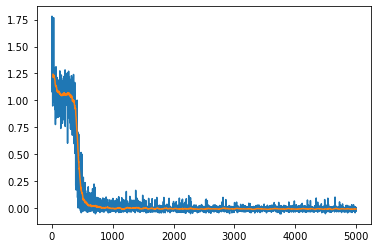

In [6]:
n = 200
p = 2
model_based = False
early_stop = False
units = 256
batch_size = 32
lr = 5e-3
max_steps = 5000

graph = 'k_nearest'  # k_nearest, kernel_based
mode = 'connectivity'    # distance, connectivity
n_neighbors = 10


seed = 42
X, label = datasets.make_circles(n_samples=n, factor=0.5, noise=0.05, random_state=seed)

K = len(np.unique(label))
embedding_dim = K


embeddings = spectral_embeddings(X, graph, mode, n_neighbors, embedding_dim)


actor = Actor(obs_dim=embedding_dim, action_dim=K, units=units)
actor_optimizer = optim.Adam(actor.parameters(), lr=lr)

# scheduler=torch.optim.lr_scheduler.StepLR(actor_optimizer, step_size=500, gamma=0.9)
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(actor_optimizer, factor=0.9, patience=10)
    
r_list = []
r_baseline = torch.tensor(0)
dictionary = dict()
# for k in range(K):
#     dictionary[k] = dict()
#     dictionary[k]['mu'] =  np.zeros(p)
#     dictionary[k]['sigma'] = np.diag([1.] * p)
kmeans = KMeans(n_clusters=K, random_state=seed).fit(embeddings)
for k in range(K):
    dictionary[k] = dict()
    dictionary[k]['mu'] =  np.mean(embeddings[kmeans.labels_ == k, ], axis=0)
    dictionary[k]['sigma'] = np.cov(embeddings[kmeans.labels_ == k, ], rowvar=False)
            

for step in range(max_steps):
    print('step: ', step)
    
    x_train = get_data(embeddings, batch_size=batch_size)    # batch size小的话，training step就要大一些
    
    actions, log_probs, _ = actor(x_train)
    
    
    # compute reward
    rewards, _, _, _ = compute_reward(x_train, K, actions.numpy(), log_probs, dictionary, model_based)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
    
    # update actor
    actor_loss = ((rewards - r_baseline) * log_probs).mean()
    # actor_loss =  (rewards * log_probs).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()       # retain_graph=True if critic is used
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    # scheduler.step(actor_loss)
    
    if early_stop & (step > 10):
            if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
                & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3) \
                & (abs(r_list[-5] - r_list[-6]) < 1e-3) & (abs(r_list[-6] - r_list[-7]) < 1e-3) \
                & (abs(r_list[-7] - r_list[-8]) < 1e-3) & (abs(r_list[-8] - r_list[-9]) < 1e-3):
            
            # if abs(np.mean(r_list[:-10]) - np.mean(r_list[:-5])) < 1e-4:
                print(f'converge at step {step}')
                break


with torch.no_grad():
    actions, log_probs, logits = actor(np.ascontiguousarray(embeddings))


plt.figure()
plt.plot(r_list)
plt.plot(pd.Series(r_list).rolling(50, 20).mean())

# Compare the results of different methods

In [9]:
print('============== "ACP" ==========================')
acp_RI, acp_MI = metrics(label, logits.argmax(dim=1))
print('acp clustering results')
print('adjusted_rand_score: ', acp_RI)
print('adjusted_mutual_info_score: ', acp_MI)

print('================ "GMM" =================================')
gm = GaussianMixture(n_components=K, n_init=1, random_state=seed).fit(X)
y_pred = gm.predict(X)
gm_RI, gm_MI = metrics(label, y_pred)
print('gm clustering results')
print('adjusted_rand_score: ', gm_RI)
print('adjusted_mutual_info_score: ', gm_MI)

print('================="K-NN"================================')
km = KMeans(n_clusters=K, random_state=seed).fit(X)
y_pred = km.predict(X)
km_RI, km_MI = metrics(label, y_pred)
print('km clustering results')
print('adjusted_rand_score: ', km_RI)
print('adjusted_mutual_info_score: ', km_MI)


print('================="SpectralClustering"================================')
sc = cluster.SpectralClustering(n_clusters=K, n_components=K, affinity='nearest_neighbors', random_state=seed).fit(X)  # rbf 依然解决不了circle问题
y_pred = sc.labels_
sc_RI, sc_MI = metrics(label, y_pred)
print('sc clustering results')
print('adjusted_rand_score: ', sc_RI)
print('adjusted_mutual_info_score: ', sc_MI)

print('================="AgglomerativeClustering"================================')
average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=K,
        ).fit(X)
y_pred = average_linkage.labels_
ac_RI, ac_MI = metrics(label, y_pred)
print('ac clustering results')
print('adjusted_rand_score: ', ac_RI)
print('adjusted_mutual_info_score: ', ac_MI)

print('================="DBSCAN"================================')
dbscan = cluster.DBSCAN(eps=0.5, min_samples=5).fit(X)
y_pred = dbscan.labels_
dbscan_RI, dbscan_MI = metrics(label, y_pred)
print('dbscan clustering results')
print('adjusted_rand_score: ', dbscan_RI)
print('adjusted_mutual_info_score: ', dbscan_MI)


print('================="OPTICS"================================')
optics = cluster.OPTICS(min_samples=5, xi=0.05).fit(X)
y_pred = optics.labels_
optics_RI, optics_MI = metrics(label, y_pred)
print('optics clustering results')
print('adjusted_rand_score: ', optics_RI)
print('adjusted_mutual_info_score: ', optics_MI)

============== "ACP" ==========================
acp clustering results
adjusted_rand_score:  1.0
adjusted_mutual_info_score:  1.0
================ "GMM" =================================
gm clustering results
adjusted_rand_score:  -0.004945432066217881
adjusted_mutual_info_score:  -0.0035760209059205557
================="K-NN"================================
km clustering results
adjusted_rand_score:  -0.004945432066217881
adjusted_mutual_info_score:  -0.0035760209059205557
================="SpectralClustering"================================
sc clustering results
adjusted_rand_score:  1.0
adjusted_mutual_info_score:  1.0
================="AgglomerativeClustering"================================
ac clustering results
adjusted_rand_score:  0.006254728877679697
adjusted_mutual_info_score:  0.006676372529713707
================="DBSCAN"================================
dbscan clustering results
adjusted_rand_score:  0.0
adjusted_mutual_info_score:  5.125482406103424e-15
================="O

Text(0.5, 1.0, 'Ground Truth')

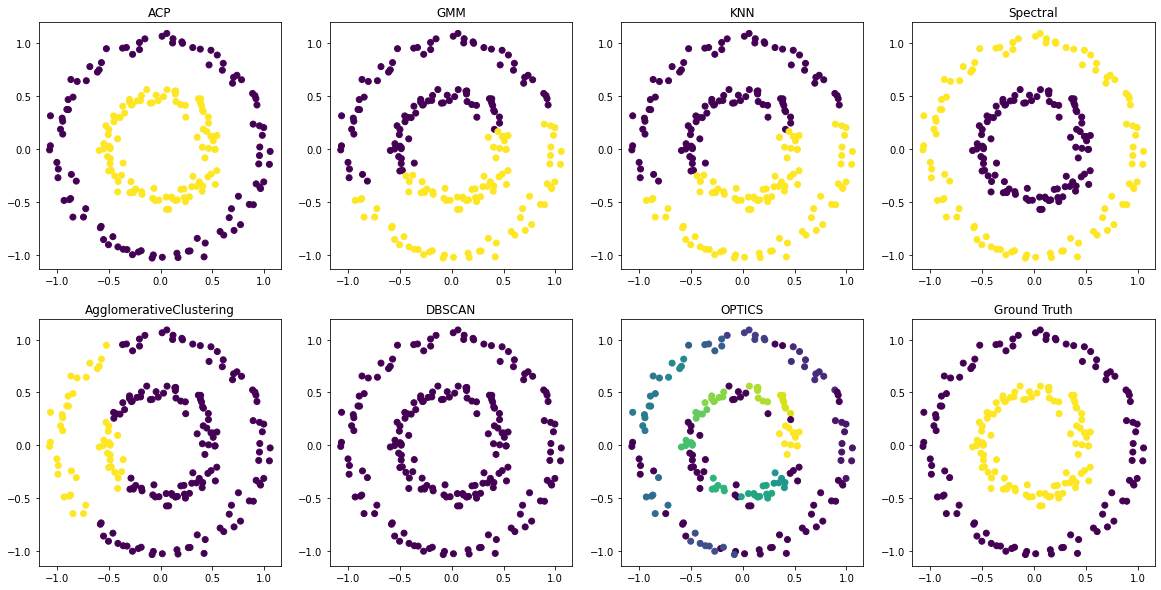

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].scatter(X[:,0], X[:, 1], c=logits.argmax(dim=1))
axes[0, 0].set_title('ACP')
axes[0, 1].scatter(X[:,0], X[:, 1], c=gm.predict(X))
axes[0, 1].set_title('GMM')
axes[0, 2].scatter(X[:,0], X[:, 1], c=km.labels_)
axes[0, 2].set_title('KNN')
axes[0, 3].scatter(X[:,0], X[:, 1], c=sc.labels_)
axes[0, 3].set_title('Spectral')
axes[1, 0].scatter(X[:,0], X[:, 1], c=average_linkage.labels_)
axes[1, 0].set_title('AgglomerativeClustering')
axes[1, 1].scatter(X[:,0], X[:, 1], c=dbscan.labels_)
axes[1, 1].set_title('DBSCAN')
axes[1, 2].scatter(X[:,0], X[:, 1], c=optics.labels_)
axes[1, 2].set_title('OPTICS')
axes[1, 3].scatter(X[:,0], X[:, 1], c=label)
axes[1, 3].set_title('Ground Truth')